# Asu Güvenli Final Project


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py
import os 
import datetime as dt
import six
import numpy as np
from tensorflow import keras
import keras

#import seaborn as sns
import sklearn as sk
#from sklearn import datasets


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:

from google.colab import drive

drive.mount('/drive',force_remount=True)

Mounted at /drive


In [ ]:
df_sig=pd.read_hdf('df_signal.h5')
df_bkg=pd.read_hdf('df_background.h5')
len(df_sig.keys())
len(df_bkg.keys())
df_sig["outcome"]=1
df_bkg["outcome"]=0


In [ ]:
df_sig.sample(frac = 1)


,br_njets,br_nbjets,br_scalar_ht,br_jet_pt_1,br_jet_pt_2,br_jet_pt_3,br_jet_pt_4,br_met,br_met_phi,br_sphericity,br_aplanarity,br_fox_wolfram_1,br_fox_wolfram_2,br_fox_wolfram_3,br_fox_wolfram_4,br_w_pt,br_w_eta,br_w_phi,br_operator_4,br_operator_9,br_operator_10,br_operator_12,br_operator_14,outcome
entry,,,,,,,,,,,,,,,,,,,,,,,,
137514,5,2,330.198975,73.681427,53.595226,39.922836,37.127396,58.718491,-0.662123,0.216696,0.036689,0.618249,0.484659,0.335649,0.247044,29.852385,-2.785993,1.714026,41161712.0,-1.245439e+15,3.315701e+14,-5.637014e+16,4.460551e+09,1
7462,8,2,390.699554,68.362610,65.015228,58.665642,36.228336,35.742607,-1.275542,0.149175,0.062446,0.597870,0.163577,0.312613,0.135360,44.859184,-2.762578,1.955093,-199021408.0,7.734131e+15,5.091725e+13,-1.056754e+17,-2.417272e+09,1
50407,4,2,559.584106,189.881973,153.482208,95.193481,60.106327,137.876297,0.915465,0.205960,0.046819,0.629859,0.205511,0.407454,0.191610,152.081818,-0.350069,-2.580706,-76211424.0,-1.738652e+16,-5.899553e+16,3.514193e+18,-6.080721e+08,1
131428,6,2,814.332703,221.185822,179.267960,144.325668,101.090401,38.521660,-0.193794,0.341757,0.051482,0.594009,0.133321,0.262014,0.154322,208.270050,-0.337396,0.310398,614292800.0,1.116414e+17,2.283411e+16,-1.484122e+19,-2.905416e+10,1
157654,5,3,362.953705,147.456558,71.506134,45.088341,25.850458,118.129402,0.392996,0.073905,0.029400,0.662838,0.604224,0.514872,0.428572,123.292320,-1.901527,-2.604402,-295616544.0,1.805029e+16,7.884971e+15,5.488899e+16,2.145621e+10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160284,7,4,327.267456,69.933327,64.772446,38.755852,38.053097,154.295563,-0.439451,0.387638,0.070293,0.577900,0.213861,0.225661,0.170192,53.556057,1.617849,-1.607153,18404944.0,8.161467e+14,-2.008146e+14,-9.621417e+16,-5.241399e+09,1
186688,5,3,313.637543,68.969521,54.629089,37.527977,33.972958,32.135426,2.638253,0.297437,0.041156,0.608344,0.464133,0.316202,0.251919,48.476048,2.157953,-0.273657,-76468432.0,-3.401159e+13,-4.179425e+14,9.687233e+16,-2.035121e+09,1
136263,5,2,387.919647,98.783394,98.741898,94.392586,32.873577,82.833443,-2.532946,0.512933,0.111600,0.611389,0.190777,0.222307,0.190015,8.359825,-3.107697,0.695970,-112575656.0,1.956915e+15,2.072230e+16,-2.223117e+17,7.523881e+09,1


/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


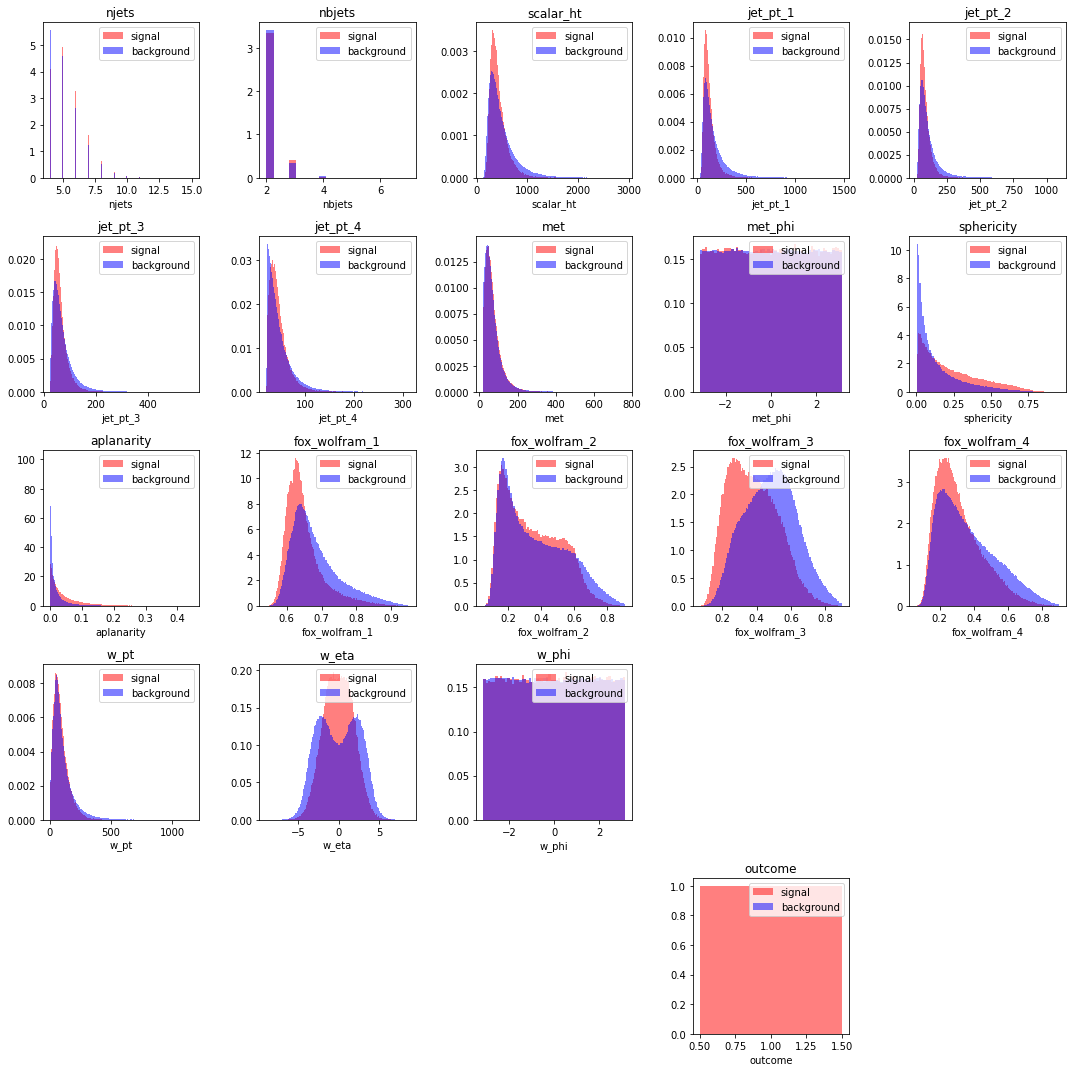

In [ ]:
plt.rcParams["figure.figsize"]=(15,15)
for i, key in enumerate(df_sig.keys()):
  if "operator" not in key:
    plt.subplot(5,5,i+1)
    _,bins,_=plt.hist(df_sig[key], bins='auto', density=True, color="r", alpha=0.5, label='signal')
    plt.xlabel(key)
    plt.hist(df_bkg[key], bins=bins, density=True, color="b", alpha=0.5, label='background')
    plt.legend(loc='best')
    plt.title(key.replace('br_',''))
    plt.xlabel(key.replace('br_',''))
    plt.tight_layout()

In [ ]:
from sklearn import utils
from tensorflow.keras.utils import to_categorical

frames=[df_sig, df_bkg]
result=pd.concat(frames)
df = utils.shuffle(result)

In [ ]:

x = df[df.keys()[:-1]].values
y = df[df.keys()[-1]].values
y.reshape(1046977,1)



from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler().fit(x)
x = scaler.transform(x)





# Classical Methods

## 1- Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression().fit(x, y)
lin.predict(x)
lin.score(x, y)

NameError: ignored

## 2- Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(random_state=0).fit(x, y)
log.predict(x[:2, :])
log.predict_proba(x[:2, :])
log.score(x, y)

## 3- K- Nearest Neighbors





In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(x[:100, :], y[:100])
neigh.predict_proba(x[:100, :])
neigh.score(x, y,sample_weight=None)

## 4- Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
bay = GaussianNB()
bay.fit(x, y)
GaussianNB()
bay.score(x,y)

## 5- Support Vector Classificiation

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x[:100, :], y[:100])

clf.score(x,y)

Looking at these results Logistic regression being the best one, SVC and k-nearest neigbourhood methods follow it up closely. We see naive bayes method is not a good fit for this task. And linear regression might be too simple for a task like this.

# Build DNN Model

In [ ]:
import keras

from keras.layers import Dense, BatchNormalization

y=to_categorical(y,num_classes=0)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, shuffle=True)

In [ ]:
from IPython.display import clear_output
class PlotLearning(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        ax1.set_yscale("log")
        
        ax2.plot(self.x, self.acc, label="accuracy({:.1f}%)".format(100*self.acc[-1]))
        
        max_acc = max(self.acc)
        
        ax2.plot(self.x, len(self.x)*[max_acc], 'b--', label="max acc. attained ({:.1f}%)".format(100*max_acc))

        ax2.plot(self.x, self.val_acc, label="validation accuracy({:.1f}%)".format(100*self.val_acc[-1]))
        
        max_val_acc = max(self.val_acc)
        
        ax2.plot(self.x, len(self.x)*[max_val_acc], 'g--', label="max val. acc. attained ({:.1f}%)".format(100*max_val_acc))
        
        ax2.legend(loc="lower right")
        plt.show()
        
plot = PlotLearning()

In [ ]:
def build_model():
    
    model = keras.Sequential()
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

    return model

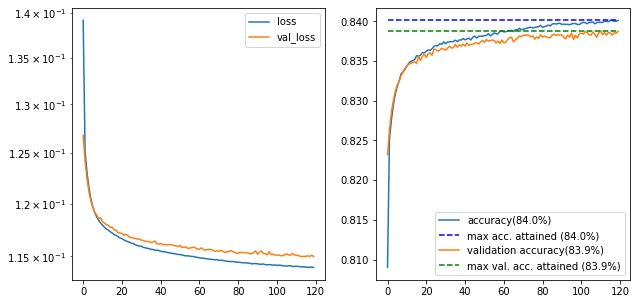

245/245 [==============================] - 2s 9ms/step - loss: 0.1140 - accuracy: 0.8401 - val_loss: 0.1150 - val_accuracy: 0.8387


In [ ]:
model1 = build_model()
model1.fit(x_train, y_train, batch_size=3000, epochs=120, validation_data=(x_test, y_test), callbacks=[PlotLearning()])

The result of the deep neural network is only slightly better than the logistic regression result. There is only 2% difference, but the time spent training the network is much larger. So it might be better to use logistic regression in this case.